In [54]:
"""
Shun-Li Shang wrote the original MATLAB code for EOS fitting.
Hui Sun converted the MATLAB code to python code.
Nigel Hew modified the python code to make it more user-friendly and added more functions.
Luke Myers performed some additional modifications to the python code.
"""

"""
This EOS fitting code is based on the following paper:
Shun-Li Shang et al., Computational Materials Science, 47, 4, (2010).
https://doi.org/10.1016/j.commatsci.2009.12.006

Equations of State:
1:  4-parameter (Teter-Shang) mBM4   1
2:  5-parameter (Teter-Shang) mBM5   2
3:  4-parameter               BM4    3
4:  5-parameter               BM5    4
5:  4-parameter Natural       Log4   5
6:  5-parameter Natural       Log5   6
7:  4-parameter Murnaghan     Mur    7
8:  4-parameter Vinet         Vinet  8
9:  4-parameter Morse         Morse  9
"""

'\nThis EOS fitting code is based on the following paper:\nShun-Li Shang et al., Computational Materials Science, 47, 4, (2010).\nhttps://doi.org/10.1016/j.commatsci.2009.12.006\n\nEquations of State:\n1:  4-parameter (Teter-Shang) mBM4   1\n2:  5-parameter (Teter-Shang) mBM5   2\n3:  4-parameter               BM4    3\n4:  5-parameter               BM5    4\n5:  4-parameter Natural       Log4   5\n6:  5-parameter Natural       Log5   6\n7:  4-parameter Murnaghan     Mur    7\n8:  4-parameter Vinet         Vinet  8\n9:  4-parameter Morse         Morse  9\n'

In [56]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import leastsq
import numpy as np
import pandas as pd
import sys
import os

sys.path.append('/storage/home/lam7027/bin/vasp-job-automation') #Change this to your path
import cstdn


ModuleNotFoundError: No module named 'eos'

In [ ]:
# Conversion factor: 1 eV/Å^3 = 160.2176621 GPa
conv_factor = 160.2176621

In [ ]:
"""
These functions are borked. The originals are too. You have to 
delete the zeroth element of the returned energy_eos and 
pressure_eos arrays
"""
def mBM4(volume, energy):
    eos_index = 1
    volume_range = np.linspace(min(volume), max(volume), 1000)

    AA = np.vstack((np.ones(np.shape(volume)), volume ** (-1 / 3), volume ** (-2 / 3), volume ** (-1)))  # (nx4)
    AA = AA.T
    xx1 = np.linalg.pinv(AA)
    xx = xx1.dot(energy)  # (4x1) = (4xn)*(nx1), solve by pseudo-inversion: Ax=b
    a = xx[0]
    b = xx[1]
    c = xx[2]
    d = xx[3]
    e = 0.0

    energy_eos = a + b * (volume_range) ** (-1 / 3) + c * (volume_range) ** (-2 / 3) + d * (volume_range) ** (
        -1) + e * (volume_range) ** (-4 / 3)
    energy_eos_points = a + b * (volume) ** (-1 / 3) + c * (volume) ** (-2 / 3) + d * (volume) ** (-1) + e * (
        volume) ** (-4 / 3)
    energy_difference = energy_eos_points - energy

    V = 4 * c ** 3 - 9 * b * c * d + np.sqrt((c ** 2 - 3 * b * d) * (4 * c ** 2 - 3 * b * d) ** 2)
    V = -V / b ** 3

    P = (4 * e) / (3 * V ** (7 / 3)) + d / V ** 2 + (2 * c) / (3 * V ** (5 / 3)) + b / (3 * V ** (4 / 3))
    P = P * conv_factor
    B = ((28 * e) / (9 * V ** (10 / 3)) + (2 * d) / V ** 3 + (10 * c) / (9 * V ** (8 / 3)) + (4 * b) / (
            9 * V ** (7 / 3))) * V
    B = B * conv_factor
    BP = (98 * e + 54 * d * V ** (1 / 3) + 25 * c * V ** (2 / 3) + 8 * b * V) / (
            42 * e + 27 * d * V ** (1 / 3) + 15 * c * V ** (2 / 3) + 6 * b * V)
    B2P = (V ** (8 / 3) * (9 * d * (14 * e + 5 * c * V ** (2 / 3) + 8 * b * V) + 2 * V ** (1 / 3) * (
            126 * b * e * V ** (1 / 3) + 5 * c * (28 * e + b * V)))) / (
                    2 * (14 * e + 9 * d * V ** (1 / 3) + 5 * c * V ** (2 / 3) + 2 * b * V) ** 3)
    B2P = B2P / conv_factor
    E0 = a + b * V ** (-1 / 3) + c * V ** (-2 / 3) + d * V ** (-1) + e * V ** (-4 / 3)
    eos_parameters = [V, E0, P, B, BP, B2P]

    fitting_error = np.array([math.sqrt(sum((energy_difference / energy) ** 2 / len(energy)))])
    results = np.concatenate(([eos_index], eos_parameters, fitting_error * (10 ** 4)))
    np.set_printoptions(precision=4, suppress=True)

    pressure_eos = ((4 * e) / (3 * volume_range ** (7 / 3)) + d / volume_range ** 2 + (2 * c) / (
            3 * volume_range ** (5 / 3)) + b / (3 * volume_range ** (4 / 3))) * conv_factor
    energy_eos = np.concatenate(([eos_index], energy_eos))
    pressure_eos = np.concatenate(([eos_index], pressure_eos))

    xini = [eos_parameters[0], eos_parameters[1], eos_parameters[3] / conv_factor,
            eos_parameters[4]]  # used for eos_index = 7 and 8
    return results, energy_eos, pressure_eos

def mBM5(volume, energy):
    eos_index = 2
    volume_range = np.linspace(min(volume), max(volume), 1000)

    AA = np.vstack(
        (np.ones(np.shape(volume)), volume ** (-1 / 3), volume ** (-2 / 3), volume ** (-1), volume ** (-4 / 3)))
    AA = AA.T
    xx1 = np.linalg.pinv(AA)
    xx = xx1.dot(energy)  # (4x1)=(4xn)*(nx1), solve by pseudo-inversion: Ax=b
    a = xx[0]
    b = xx[1]
    c = xx[2]
    d = xx[3]
    e = xx[4]

    energy_eos = a + b * (volume_range) ** (-1 / 3) + c * (volume_range) ** (-2 / 3) + d * (volume_range) ** (
        -1) + e * (volume_range) ** (-4 / 3)
    energy_eos_points = a + b * (volume) ** (-1 / 3) + c * (volume) ** (-2 / 3) + d * (volume) ** (-1) + e * (
        volume) ** (-4 / 3)
    energy_difference = energy_eos_points - energy

    func = lambda volume_range: ((4 * e) / (3 * volume_range ** (7 / 3)) + d / volume_range ** 2 + (2 * c) / (
            3 * volume_range ** (5 / 3)) + b / (
                                            3 * volume_range ** (4 / 3))) * conv_factor
    V = fsolve(func, np.mean(volume))
    P = (4 * e) / (3 * V ** (7 / 3)) + d / V ** 2 + (2 * c) / (3 * V ** (5 / 3)) + b / (3 * V ** (4 / 3))
    P = P * conv_factor
    B = ((28 * e) / (9 * V ** (10 / 3)) + (2 * d) / V ** 3 + (10 * c) / (9 * V ** (8 / 3)) + (4 * b) / (
            9 * V ** (7 / 3))) * V
    B = B * conv_factor
    BP = (98 * e + 54 * d * V ** (1 / 3) + 25 * c * V ** (2 / 3) + 8 * b * V) / (
            42 * e + 27 * d * V ** (1 / 3) + 15 * c * V ** (2 / 3) + 6 * b * V)
    B2P = (V ** (8 / 3) * (9 * d * (14 * e + 5 * c * V ** (2 / 3) + 8 * b * V) + 2 * V ** (1 / 3) * (
            126 * b * e * V ** (1 / 3) + 5 * c * (28 * e + b * V)))) / (
                    2 * (14 * e + 9 * d * V ** (1 / 3) + 5 * c * V ** (2 / 3) + 2 * b * V) ** 3)
    B2P = B2P / conv_factor
    E0 = a + b * V ** (-1 / 3) + c * V ** (-2 / 3) + d * V ** (-1) + e * V ** (-4 / 3)
    eos_parameters = [V, E0, P, B, BP, B2P]

    fitting_error = np.array([math.sqrt(sum((energy_difference / energy) ** 2 / len(energy)))])
    results = np.concatenate(([eos_index], *eos_parameters, fitting_error * (10 ** 4)))
    np.set_printoptions(precision=4, suppress=True)

    pressure_eos = ((4 * e) / (3 * volume_range ** (7 / 3)) + d / volume_range ** 2 + (2 * c) / (
            3 * volume_range ** (5 / 3)) + b / (
                            3 * volume_range ** (4 / 3))) * conv_factor
    energy_eos = np.concatenate(([eos_index], energy_eos))
    pressure_eos = np.concatenate(([eos_index], pressure_eos))

    return results, energy_eos, pressure_eos

def BM4(volume, energy):
    eos_index = 3
    volume_range = np.linspace(min(volume), max(volume), 1000)

    AA = np.vstack((np.ones(np.shape(volume)), volume ** (-2 / 3), volume ** (-4 / 3), volume ** (-2)))
    AA = AA.T
    xx1 = np.linalg.pinv(AA)
    xx = xx1.dot(energy)  # (4x1)=(4xn)*(nx1), solve by pseudo-inversion: Ax=b
    a = xx[0]
    b = xx[1]
    c = xx[2]
    d = xx[3]
    e = 0.0

    energy_eos = a + b * (volume_range) ** (-2 / 3) + c * (volume_range) ** (-4 / 3) + d * (volume_range) ** (
        -2) + e * (volume_range) ** (-8 / 3)
    energy_eos_points = a + b * (volume) ** (-2 / 3) + c * (volume) ** (-4 / 3) + d * (volume) ** (-2) + e * (
        volume) ** (-8 / 3)
    energy_difference = energy_eos_points - energy

    V = math.sqrt(-((4 * c ** 3 - 9 * b * c * d + math.sqrt(
        (c ** 2 - 3 * b * d) * (4 * c ** 2 - 3 * b * d) ** 2)) / b ** 3))
    P = (8 * e) / (3 * V ** (11 / 3)) + (2 * d) / V ** 3 + (4 * c) / (3 * V ** (7 / 3)) + (2 * b) / (
            3 * V ** (5 / 3))
    P = P * conv_factor
    B = (2 * (44 * e + 27 * d * V ** (2 / 3) + 14 * c * V ** (4 / 3) + 5 * b * V ** 2)) / (9 * V ** (11 / 3))
    B = B * conv_factor
    BP = (484 * e + 243 * d * V ** (2 / 3) + 98 * c * V ** (4 / 3) + 25 * b * V ** 2) / (
            132 * e + 81 * d * V ** (2 / 3) + 42 * c * V ** (4 / 3) + 15 * b * V ** 2);
    B2P = (4 * V ** (13 / 3) * (27 * d * (22 * e + 7 * c * V ** (4 / 3) + 10 * b * V ** 2) + V ** (2 / 3) * (
            990 * b * e * V ** (2 / 3) + 7 * c * (176 * e + 5 * b * V ** 2)))) / (
                    44 * e + 27 * d * V ** (2 / 3) + 14 * c * V ** (4 / 3) + 5 * b * V ** 2) ** 3
    B2P = B2P / conv_factor
    E0 = a + e / V ** (8 / 3) + d / V ** 2 + c / V ** (4 / 3) + b / V ** (2 / 3)
    eos_parameters = [V, E0, P, B, BP, B2P]

    fitting_error = np.array([math.sqrt(sum((energy_difference / energy) ** 2 / len(energy)))])

    results = np.concatenate(([eos_index], eos_parameters, fitting_error * (10 ** 4)))
    np.set_printoptions(precision=4, suppress=True)

    pressure_eos = ((8 * e) / (3 * volume_range ** (11 / 3)) + (2 * d) / volume_range ** 3 + (4 * c) / (
            3 * volume_range ** (7 / 3)) + (2 * b) / (
                            3 * volume_range ** (5 / 3))) * conv_factor
    energy_eos = np.concatenate(([eos_index], energy_eos))
    pressure_eos = np.concatenate(([eos_index], pressure_eos))

    return results, energy_eos, pressure_eos

def BM5(volume, energy):
    eos_index = 4
    volume_range = np.linspace(min(volume), max(volume), 1000)

    AA = np.vstack(
        (np.ones(np.shape(volume)), volume ** (-2 / 3), volume ** (-4 / 3), volume ** (-2), volume ** (-8 / 3)))
    AA = AA.T
    xx1 = np.linalg.pinv(AA)
    xx = xx1.dot(energy)  # (4x1)=(4xn)*(nx1), solve by pseudo-inversion: Ax=b
    a = xx[0]
    b = xx[1]
    c = xx[2]
    d = xx[3]
    e = xx[4]

    energy_eos = a + b * (volume_range) ** (-2 / 3) + c * (volume_range) ** (-4 / 3) + d * (volume_range) ** (
        -2) + e * (volume_range) ** (-8 / 3)
    energy_eos_points = a + b * (volume) ** (-2 / 3) + c * (volume) ** (-4 / 3) + d * (volume) ** (-2) + e * (
        volume) ** (-8 / 3)
    energy_difference = energy_eos_points - energy

    func = lambda volume_range: ((8 * e) / (3 * volume_range ** (11 / 3)) + (2 * d) / volume_range ** 3 + (
            4 * c) / (3 * volume_range ** (7 / 3)) + (2 * b) / (3 * volume_range ** (5 / 3))) * conv_factor
    V = fsolve(func, np.mean(volume))
    P = (8 * e) / (3 * V ** (11 / 3)) + (2 * d) / V ** 3 + (4 * c) / (3 * V ** (7 / 3)) + (2 * b) / (
            3 * V ** (5 / 3))
    P = P * conv_factor
    B = (2 * (44 * e + 27 * d * V ** (2 / 3) + 14 * c * V ** (4 / 3) + 5 * b * V ** 2)) / (9 * V ** (11 / 3))
    B = B * conv_factor
    BP = (484 * e + 243 * d * V ** (2 / 3) + 98 * c * V ** (4 / 3) + 25 * b * V ** 2) / (
            132 * e + 81 * d * V ** (2 / 3) + 42 * c * V ** (4 / 3) + 15 * b * V ** 2);
    B2P = (4 * V ** (13 / 3) * (27 * d * (22 * e + 7 * c * V ** (4 / 3) + 10 * b * V ** 2) + V ** (2 / 3) * (
            990 * b * e * V ** (2 / 3) + 7 * c * (176 * e + 5 * b * V ** 2)))) / (
                    44 * e + 27 * d * V ** (2 / 3) + 14 * c * V ** (4 / 3) + 5 * b * V ** 2) ** 3
    B2P = B2P / conv_factor
    E0 = a + e / V ** (8 / 3) + d / V ** 2 + c / V ** (4 / 3) + b / V ** (2 / 3)
    eos_parameters = [V, E0, P, B, BP, B2P]

    fitting_error = np.array([math.sqrt(sum((energy_difference / energy) ** 2 / len(energy)))])
    results = np.concatenate(([eos_index], *eos_parameters, fitting_error * (10 ** 4)))
    np.set_printoptions(precision=4, suppress=True)

    pressure_eos = ((8 * e) / (3 * volume_range ** (11 / 3)) + (2 * d) / volume_range ** 3 + (4 * c) / (
            3 * volume_range ** (7 / 3)) + (2 * b) / (3 * volume_range ** (5 / 3))) * conv_factor
    energy_eos = np.concatenate(([eos_index], energy_eos))
    pressure_eos = np.concatenate(([eos_index], pressure_eos))

    return results, energy_eos, pressure_eos

def LOG4(volume, energy):
    eos_index = 5
    volume_range = np.linspace(min(volume), max(volume), 1000)

    AA = np.vstack((np.ones(np.shape(volume)), np.log(volume), np.log(volume) ** 2, np.log(volume) ** 3))
    AA = AA.T
    xx1 = np.linalg.pinv(AA)
    xx = xx1.dot(energy)  # (4x1)=(4xn)*(nx1), solve by pseudo-inversion: Ax=b
    a = xx[0]
    b = xx[1]
    c = xx[2]
    d = xx[3]
    e = 0.0

    energy_eos = a + b * np.log(volume_range) + c * np.log(volume_range) ** 2 + d * np.log(
        volume_range) ** 3 + e * np.log(volume_range) ** 4
    energy_eos_points = a + b * np.log(volume) + c * np.log(volume) ** 2 + d * np.log(volume) ** 3 + e * np.log(
        volume) ** 4
    energy_difference = energy_eos_points - energy

    func = lambda volume_range: (-(
            (b + 2 * c * math.log(volume_range) + 3 * d * math.log(volume_range) ** 2 + 4 * e * math.log(
                volume_range) ** 3) / volume_range)) * conv_factor
    V = fsolve(func, np.mean(volume))
    V = np.mean(V)
    P = -((b + 2 * c * math.log(V) + 3 * d * math.log(V) ** 2 + 4 * e * math.log(V) ** 3) / V)
    P = np.mean(P)
    P = P * conv_factor
    B = -((b - 2 * c + 2 * (c - 3 * d) * math.log(V) + 3 * (d - 4 * e) * math.log(V) ** 2 + 4 * e * math.log(
        V) ** 3) / V)
    B = np.mean(B)
    B = B * conv_factor
    BP = (b - 4 * c + 6 * d + 2 * (c - 6 * d + 12 * e) * math.log(V) + 3 * (d - 8 * e) * math.log(
        V) ** 2 + 4 * e * math.log(V) ** 3) / (
                    b - 2 * c + 2 * (c - 3 * d) * math.log(V) + 3 * (d - 4 * e) * math.log(
                V) ** 2 + 4 * e * math.log(V) ** 3)
    B2P = (2 * V * (2 * c ** 2 - 3 * b * d + 18 * d ** 2 + 12 * b * e - 6 * c * (d + 4 * e) + 6 * (
            c * d - 3 * d ** 2 - 2 * b * e + 12 * d * e) * math.log(V) + 9 * (d - 4 * e) ** 2 * math.log(
        V) ** 2 + 24 * (d - 4 * e) * e * math.log(V) ** 3 + 24 * e ** 2 * math.log(V) ** 4)) / (
                    b - 2 * c + 2 * (c - 3 * d) * math.log(V) + 3 * (d - 4 * e) * math.log(
                V) ** 2 + 4 * e * math.log(V) ** 3) ** 3
    B2P = np.mean(B2P)
    B2P = B2P / conv_factor
    E0 = a + b * math.log(V) + c * math.log(V) ** 2 + d * math.log(V) ** 3 + e * math.log(V) ** 4
    eos_parameters = [V, E0, P, B, BP, B2P]

    fitting_error = np.array([math.sqrt(sum((energy_difference / energy) ** 2 / len(energy)))])
    results = np.concatenate(([eos_index], eos_parameters, fitting_error * (10 ** 4)))
    np.set_printoptions(precision=4, suppress=True)

    pressure_eos = (-((b + 2 * c * np.log(volume_range) + 3 * d * np.log(volume_range) ** 2 + 4 * e * np.log(
        volume_range) ** 3) / volume_range)) * conv_factor
    energy_eos = np.concatenate(([eos_index], energy_eos))
    pressure_eos = np.concatenate(([eos_index], pressure_eos))

    return results, energy_eos, pressure_eos

def LOG5(volume, energy):
    eos_index = 6
    volume_range = np.linspace(min(volume), max(volume), 1000)

    AA = np.vstack(
        (np.ones(np.shape(volume)), np.log(volume), np.log(volume) ** 2, np.log(volume) ** 3, np.log(volume) ** 4))
    AA = AA.T
    xx1 = np.linalg.pinv(AA)
    xx = xx1.dot(energy)  # (4x1)=(4xn)*(nx1), solve by pseudo-inversion: Ax=b
    a = xx[0]
    b = xx[1]
    c = xx[2]
    d = xx[3]
    e = xx[4]

    energy_eos = a + b * np.log(volume_range) + c * np.log(volume_range) ** 2 + d * np.log(
        volume_range) ** 3 + e * np.log(volume_range) ** 4
    energy_eos_points = a + b * np.log(volume) + c * np.log(volume) ** 2 + d * np.log(volume) ** 3 + e * np.log(
        volume) ** 4
    energy_difference = energy_eos_points - energy

    func = lambda volume_range: (-(
            (b + 2 * c * math.log(volume_range) + 3 * d * math.log(volume_range) ** 2 + 4 * e * math.log(
                volume_range) ** 3) / volume_range)) * conv_factor
    V = fsolve(func, np.mean(volume))
    V = np.mean(V)
    P = -((b + 2 * c * math.log(V) + 3 * d * math.log(V) ** 2 + 4 * e * math.log(V) ** 3) / V)
    P = np.mean(P)
    P = P * conv_factor
    B = -((b - 2 * c + 2 * (c - 3 * d) * math.log(V) + 3 * (d - 4 * e) * math.log(V) ** 2 + 4 * e * math.log(
        V) ** 3) / V)
    B = np.mean(B)
    B = B * conv_factor
    BP = (b - 4 * c + 6 * d + 2 * (c - 6 * d + 12 * e) * math.log(V) + 3 * (d - 8 * e) * math.log(
        V) ** 2 + 4 * e * math.log(V) ** 3) / (
                    b - 2 * c + 2 * (c - 3 * d) * math.log(V) + 3 * (d - 4 * e) * math.log(
                V) ** 2 + 4 * e * math.log(V) ** 3)
    B2P = (2 * V * (2 * c ** 2 - 3 * b * d + 18 * d ** 2 + 12 * b * e - 6 * c * (d + 4 * e) + 6 * (
            c * d - 3 * d ** 2 - 2 * b * e + 12 * d * e) * math.log(V) + 9 * (d - 4 * e) ** 2 * math.log(
        V) ** 2 + 24 * (d - 4 * e) * e * math.log(V) ** 3 + 24 * e ** 2 * math.log(V) ** 4)) / (
                    b - 2 * c + 2 * (c - 3 * d) * math.log(V) + 3 * (d - 4 * e) * math.log(
                V) ** 2 + 4 * e * math.log(V) ** 3) ** 3
    B2P = np.mean(B2P)
    B2P = B2P / conv_factor
    E0 = a + b * math.log(V) + c * math.log(V) ** 2 + d * math.log(V) ** 3 + e * math.log(V) ** 4
    eos_parameters = [V, E0, P, B, BP, B2P]

    fitting_error = np.array([math.sqrt(sum((energy_difference / energy) ** 2 / len(energy)))])
    results = np.concatenate(([eos_index], eos_parameters, fitting_error * (10 ** 4)))
    np.set_printoptions(precision=4, suppress=True)

    pressure_eos = (-((b + 2 * c * np.log(volume_range) + 3 * d * np.log(volume_range) ** 2 + 4 * e * np.log(
        volume_range) ** 3) / volume_range)) * conv_factor
    energy_eos = np.concatenate(([eos_index], energy_eos))
    pressure_eos = np.concatenate(([eos_index], pressure_eos))

    return results, energy_eos, pressure_eos

def murnaghan_eq(xini, Data):
    V = xini[0]
    E0 = xini[1]
    B = xini[2]
    bp = xini[3]
    volume_range = Data[:, 0]
    y = Data[:, 1]
    eng = E0 - (B * V) / (-1 + bp) + (B * (1 + (V / volume_range) ** bp / (-1 + bp)) * volume_range) / bp
    return eng - y

def murnaghan(volume, energy):
    eos_index = 7
    volume_range = np.linspace(min(volume), max(volume), 1000)

    volume = volume
    Data = np.vstack((volume, energy))
    Data = Data.T

    [results, energy_eos, pressure_eos] = mBM4(volume, energy)
    xini = [results[1], results[2], results[4] / conv_factor, results[5]]
    [xout, resnorm] = leastsq(murnaghan_eq, xini, Data)

    V = xout[0]
    E0 = xout[1]
    B = xout[2]
    bp = xout[3]

    energy_eos = E0 - (B * V) / (-1 + bp) + (B * (1 + (V / volume_range) ** bp / (-1 + bp)) * volume_range) / bp
    energy_eos_points = (E0 - (B * V) / (-1 + bp) + (B * (1 + (V / volume) ** bp / (-1 + bp)) * volume) / bp)
    energy_difference = energy_eos_points - energy
    eos_parameters = [V, E0, 0, B * conv_factor, bp, 0]

    fitting_error = np.array([math.sqrt(sum((energy_difference / energy) ** 2 / len(energy)))])
    results = np.concatenate(([eos_index], eos_parameters, fitting_error * (10 ** 4)))
    np.set_printoptions(precision=4, suppress=True)

    pressure_eos = conv_factor * (B * (-1 + (V / volume_range) ** bp)) / bp
    energy_eos = np.concatenate(([eos_index], energy_eos))
    pressure_eos = np.concatenate(([eos_index], pressure_eos))

    return results, energy_eos, pressure_eos

def vinet_eq(xini, Data):
    V = xini[0]
    E0 = xini[1]
    B = xini[2]
    bp = xini[3]
    volume_range = Data[:, 0]
    y = Data[:, 1]
    eng = E0 + (4 * B * V) / (-1 + bp) ** 2 - (
            4 * B * V * (1 + (3 * (-1 + bp) * (-1 + (volume_range / V) ** (1 / 3))) / 2)) / (
                    (-1 + bp) ** 2 * np.exp((3 * (-1 + bp) * (-1 + (volume_range / V) ** (1 / 3))) / 2))
    return eng - y

def vinet(volume, energy):
    eos_index = 8
    volume_range = np.linspace(min(volume), max(volume), 1000)

    Data = np.vstack((volume, energy))
    Data = Data.T

    [results, energy_eos, pressure_eos] = mBM4(volume, energy)
    xini = [results[1], results[2], results[4] / conv_factor, results[5]]
    [xout, resnorm] = leastsq(vinet_eq, xini, Data)
    V = xout[0]
    E0 = xout[1]
    B = xout[2]
    bp = xout[3]

    energy_eos = E0 + (4 * B * V) / (-1 + bp) ** 2 - (
            4 * B * V * (1 + (3 * (-1 + bp) * (-1 + (volume_range / V) ** (1 / 3))) / 2)) / (
                            (-1 + bp) ** 2 * np.exp((3 * (-1 + bp) * (-1 + (volume_range / V) ** (1 / 3))) / 2))
    energy_eos_points = E0 + (4 * B * V) / (-1 + bp) ** 2 - (
            4 * B * V * (1 + (3 * (-1 + bp) * (-1 + (volume / V) ** (1 / 3))) / 2)) / (
                                (-1 + bp) ** 2 * np.exp((3 * (-1 + bp) * (-1 + (volume / V) ** (1 / 3))) / 2))
    energy_difference = energy_eos_points - energy

    b2p = (19 - 18 * bp - 9 * bp ** 2) / (36 * B)
    eos_parameters = [V, E0, 0, B * conv_factor, bp, b2p / conv_factor]

    fitting_error = np.array([math.sqrt(sum((energy_difference / energy) ** 2 / len(energy)))])
    results = np.concatenate(([eos_index], eos_parameters, fitting_error * (10 ** 4)))
    np.set_printoptions(precision=4, suppress=True)

    pressure_eos = conv_factor * (-3 * B * (-1 + (volume_range / V) ** (1 / 3))) / (
            np.exp((3 * (-1 + bp) * (-1 + (volume_range / V) ** (1 / 3))) / 2) * (volume_range / V) ** (2 / 3))
    energy_eos = np.concatenate(([eos_index], energy_eos))
    pressure_eos = np.concatenate(([eos_index], pressure_eos))

    return results, energy_eos, pressure_eos

def morse_eq(xini, Data):
    V = xini[0]
    E0 = xini[1]
    B = xini[2]
    bp = xini[3]

    a = E0 + (9 * B * V) / (2 * (-1 + bp) ** 2)
    b = (-9 * B * np.exp(-1 + bp) * V) / (-1 + bp) ** 2
    c = (9 * B * np.exp(-2 + 2 * bp) * V) / (2 * (-1 + bp) ** 2)
    d = (1 - bp) / V ** (1 / 3)
    volume_range = Data[:, 0]
    y = Data[:, 1]
    eng = a + b * np.exp(d * volume_range ** (1 / 3)) + c * np.exp(2 * d * volume_range ** (1 / 3))
    return eng - y

def morse(volume, energy):
    eos_index = 9
    volume_range = np.linspace(min(volume), max(volume), 1000)

    Data = np.vstack((volume, energy))
    Data = Data.T

    [results, energy_eos, pressure_eos] = mBM4(volume, energy)
    xini = [results[1], results[2], results[4] / conv_factor,
            results[5]]
    [xout, resnorm] = leastsq(morse_eq, xini, Data)
    V = xout[0]
    E0 = xout[1]
    B = xout[2]
    bp = xout[3]

    a = E0 + (9 * B * V) / (2 * (-1 + bp) ** 2)
    b = (-9 * B * np.exp(-1 + bp) * V) / (-1 + bp) ** 2
    c = (9 * B * np.exp(-2 + 2 * bp) * V) / (2 * (-1 + bp) ** 2)
    d = (1 - bp) / V ** (1 / 3)

    energy_eos = a + b * np.exp(d * volume_range ** (1 / 3)) + c * np.exp(2 * d * volume_range ** (1 / 3))
    energy_eos_points = a + b * np.exp(d * volume ** (1 / 3)) + c * np.exp(2 * d * volume ** (1 / 3))
    energy_difference = energy_eos_points - energy

    b2p = (5 - 5 * bp - 2 * bp ** 2) / (9 * B)
    eos_parameters = [V, E0, 0, B * conv_factor, bp, b2p / conv_factor]

    fitting_error = np.array([math.sqrt(sum((energy_difference / energy) ** 2 / len(energy)))])
    results = np.concatenate(([eos_index], eos_parameters, fitting_error * (10 ** 4)))
    np.set_printoptions(precision=4, suppress=True)

    pressure_eos = -conv_factor * (
            d * np.exp(d * volume_range ** (1 / 3)) * (b + 2 * c * np.exp(d * volume_range ** (1 / 3)))) / (
                            3 * volume_range ** (2 / 3))
    energy_eos = np.concatenate(([eos_index], energy_eos))
    pressure_eos = np.concatenate(([eos_index], pressure_eos))

    return results, energy_eos, pressure_eos


In [ ]:
"""
df argument must be a dataframe of single configuration containing all the volumes and energies
"""

def fit_to_all_eos(df): # must be a df for a single configuration 
    volumes = df['volume']
    energies = df['energy']


In [ ]:
energy = np.array([-.23101990E+03,
-.23108470E+03,
-.23114435E+03,
-.23119627E+03,
-.23123549E+03,
-.23125578E+03,
-.23125810E+03,
-.23123352E+03,
-.23117630E+03,
-.23107862E+03,
-.23093777E+03,
-.23074292E+03,
-.23049160E+03,
-.23017976E+03,
-.22980665E+03])

volume = np.array([370.000000,
362.857143,
355.714286,
348.571429,
341.428571,
334.285714,
327.142857,
320.000000,
312.857143,
305.714286,
298.571429,
291.428571,
284.285714,
277.142857,
270.000000])

In [ ]:
results, energy_eos, pressure_eos = morse(volume, energy)
print(type(results))
print(results)

<class 'numpy.ndarray'>
[   9.      331.6765 -231.2609    0.       24.1705    6.7438   -0.5501
    0.3131]


<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

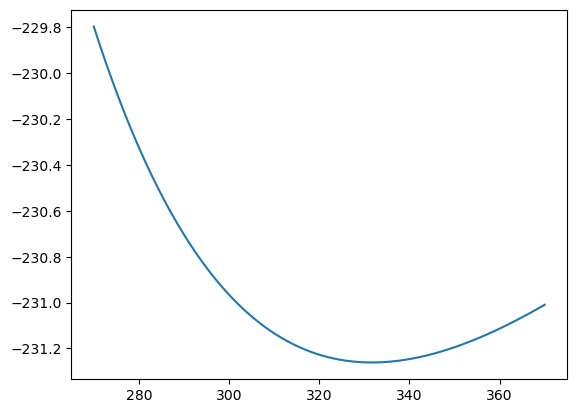

In [ ]:
volumes = np.linspace(min(volume), max(volume), 1000)
plt.plot(volumes, energy_eos[1:])
plt.plot

In [ ]:
ion_list = [i for i in range(1, 9)] #recall that range(n, m) = [n, ..., m-1]
config_dir = '/storage/home/lam7027/work/FeSe/cmme_2x2x1_vol_series_r2scan_rvv10_fixed_poscar/configurations/config_16'

df = cstdn.extract_config_data(config_dir, ion_list, outcar_name='OUTCAR.2relax', oszicar_name='OSZICAR.2relax') # get the data 


NameError: name 'cstdn' is not defined